In [2]:
%load_ext autoreload
%autoreload 2

In [131]:
import os
import terra
import meerkat as mk
from domino.data.visual_genome import read_vg, ATTRIBUTE_GROUPS
import numpy as np
import pandas as pd
from rich import print
import sys
sys.path.insert(1,'/pd/maya/domino/domino')

In [152]:
#for p in sys.path:
#    print(p)

## MIMIC Slice Experiments

### Generate Slices

In [133]:
import slices.mimic

In [134]:
dataset_dir = '/pd/maya/mimic_dp_adjusted_diagnoses.mk'

In [135]:
target = 'lung_group'
correlate = 'support_devices'

In [136]:
dp = slices.mimic.build_correlation_slice(target, correlate, 0.8, 1e4, dataset_dir)
dp.shape

(9997, 66)

In [137]:
print('target: ' + target + f'==1: {np.sum(dp[target]==1)}')
print('correlate: ' + correlate + f'==1: {np.sum(dp[correlate]==1)}')
print(f'{target}==1 and {correlate}==1: {np.sum((dp[correlate]==1) & (dp[target]==1))}')
print(f'{target}==0 and {correlate}==0: {np.sum((dp[correlate]==0) & (dp[target]==0))}')
print(f'{target}==1 and {correlate}==0: {np.sum((dp[correlate]==0) & (dp[target]==1))}')
print(f'{target}==0 and {correlate}==1: {np.sum((dp[correlate]==1) & (dp[target]==0))}')

target: lung_group==1: 2228

correlate: support_devices==1: 2228

lung_group==1 and support_devices==1: 1882

lung_group==0 and support_devices==0: 7423

lung_group==1 and support_devices==0: 346

lung_group==0 and support_devices==1: 346

In [138]:
import utils

In [139]:
splits = utils.split_dp(dp, split_on="dicom_id")

task: split_dp, run_id=6664


,dicom_id (PandasSeriesColumn),study_id (PandasSeriesColumn),subject_id (PandasSeriesColumn),dicom_path (PandasSeriesColumn),gender (PandasSeriesColumn),anchor_age (PandasSeriesColumn),anchor_year (PandasSeriesColumn),anchor_year_group (PandasSeriesColumn),dod (PandasSeriesColumn),dicom (PandasSeriesColumn),study_date (PandasSeriesColumn),image_type (PandasSeriesColumn),table_type (PandasSeriesColumn),distance_source_to_detector (PandasSeriesColumn),distance_source_to_patient (PandasSeriesColumn),exposure (PandasSeriesColumn),exposure_time (PandasSeriesColumn),x_ray_tube_current (PandasSeriesColumn),field_of_view_rotation (PandasSeriesColumn),field_of_view_origin (PandasSeriesColumn),field_of_view_horizontal_flip (PandasSeriesColumn),view_position (PandasSeriesColumn),patient_orientation (PandasSeriesColumn),burned_in_annotation (PandasSeriesColumn),requesting_service (PandasSeriesColumn),detector_primary_angle (PandasSeriesColumn),detector_element_physical_size (PandasSeriesColumn),report_path (PandasSeriesColumn),hadm_id (PandasSeriesColumn),admittime (PandasSeriesColumn),dischtime (PandasSeriesColumn),deathtime (PandasSeriesColumn),admission_type (PandasSeriesColumn),admission_location (PandasSeriesColumn),discharge_location (PandasSeriesColumn),insurance (PandasSeriesColumn),language (PandasSeriesColumn),marital_status (PandasSeriesColumn),ethnicity (PandasSeriesColumn),edregtime (PandasSeriesColumn),edouttime (PandasSeriesColumn),hospital_expire_flag (PandasSeriesColumn),index (PandasSeriesColumn),jpg_path (PandasSeriesColumn),cxr_jpg (GCSImageColumn),cxr_dicom (GCSImageColumn),cxr_jpg_1024 (ImageColumn),atelectasis (PandasSeriesColumn),cardiomegaly (PandasSeriesColumn),consolidation (PandasSeriesColumn),edema (PandasSeriesColumn),enlarged_cardiomediastinum (PandasSeriesColumn),fracture (PandasSeriesColumn),lung_lesion (PandasSeriesColumn),lung_opacity (PandasSeriesColumn),no_finding (PandasSeriesColumn),pleural_effusion (PandasSeriesColumn),pleural_other (PandasSeriesColumn),pneumonia (PandasSeriesColumn),pneumothorax (PandasSeriesColumn),support_devices (PandasSeriesColumn),finding_group (PandasSeriesColumn),lung_group (PandasSeriesColumn),pleural_group (PandasSeriesColumn),cardio_group (PandasSeriesColumn),split (PandasSeriesColumn)
0,6c73c449-fd189870-9c0a6ef8-8a7199a7-f31f91c1,50270254,13860898,files/p13/p13860898/s50270254/6c73c449-fd189870-9c0a6ef8-8a7199a7-f31f91c1.dcm,F,39.0,2146.0,2008 - 2010,None,6c73c449-fd189870-9c0a6ef8-8a7199a7-f31f91c1,21521219.0,"['ORIGINAL', 'PRIMARY']",None,1828.0,1779.0,4.0,13.0,320.0,0.0,"['133', '0']",NO,PA,"['L', 'F']",NO,MED,NaN,"['0.200000', '0.200000']",files/p13/p13860898/s50270254.txt,21454248.0,2152-12-17 23:02:00,2152-12-22 16:30:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Other,ENGLISH,DIVORCED,BLACK/AFRICAN AMERICAN,2152-12-17 18:09:00,2152-12-18 01:54:00,0.0,205956,files/p13/p13860898/s50270254/6c73c449-fd189870-9c0a6ef8-8a7199a7-f31f91c1.jpg,LambdaCell,LambdaCell,,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,False,False,False,train
1,f2210b32-7f329881-b2e73148-a55a1daa-8145ad1c,53899167,12900275,files/p12/p12900275/s53899167/f2210b32-7f329881-b2e73148-a55a1daa-8145ad1c.dcm,M,57.0,2129.0,2014 - 2016,None,f2210b32-7f329881-b2e73148-a55a1daa-8145ad1c,21300417.0,"['DERIVED', 'PRIMARY']",TILTING,NaN,NaN,4.0,13.0,320.0,NaN,None,None,AP,"['L', 'F']",YES,SURG,NaN,"['0.139', '0.139']",files/p12/p12900275/s53899167.txt,25394720.0,2130-04-17 11:03:00,2130-04-23 15:26:00,NaT,URGENT,TRANSFER FROM SKILLED NURSING FACILITY,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,DIVORCED,WHITE,NaT,NaT,0.0,197473,files/p12/p12900275/s53899167/f2210b32-7f329881-b2e73148-a55a1daa-8145ad1c.jpg,LambdaCell,LambdaCell,,0,0,0,0,0,0,0,0,1,0,0,0,0,1,True,False,False,False,train
2,7d5e7bab-1723c246-bf63bbf8-e207c40e-06cf4251,57512939,13706076,files/p13/p13706076/s57512939/7d5e7bab-1723c246-bf63bbf8-e207c40e-06cf4251.dcm,F,76.0,2157.0,2008 - 2010,None,7d5e7bab-1723c246-bf63bbf8-e207c40e-06cf4251,21601216.0,"['DERIVED', 'PRIMARY', 
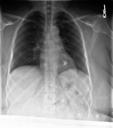
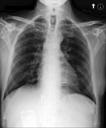
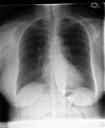
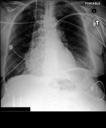
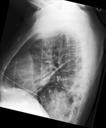

In [140]:
splits = splits.load()
dp['split'] = splits['split']
dp.head()

### Train Model

In [13]:
import terra 
from vision import train
from torchvision import transforms

preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


dp["input"] = dp["cxr_jpg_1024"].to_lambda(preprocessing)

@terra.Task
def train_vg(dp, run_dir: str = None):

    model = train(
        config={"pretrained": True, 'transform': None, 'train_transform': None},
        dp=dp,
        input_column="input",
        max_epochs=5,
        id_column="dicom_id",
        target_column=target,
        ckpt_monitor="valid_auroc",
        batch_size=128, 
        run_dir=run_dir,
        val_check_interval=10,
        num_workers=6
    )
    return model

train_vg(dp=dp)

/home/sabri/code/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


task: train_vg, run_id=6186


[2021-09-14 20:45:31,454][INFO][pytorch_lightning.utilities.seed:65] :: Global seed set to 123
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory /home/sabri/terra/slice/tasks/__main__/train_vg/_runs/6186 exists and is not empty.
  warnings.warn(*args, **kwargs)
[2021-09-14 20:45:35,289][INFO][pytorch_lightning.utilities.distributed:73] :: GPU available: True, used: True
[2021-09-14 20:45:35,290][INFO][pytorch_lightning.utilities.distributed:73] :: TPU available: False, using: 0 TPU cores
[2021-09-14 20:45:35,311][INFO][pytorch_lightning.accelerators.gpu:63] :: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged i

[2021-09-14 20:45:42,060][INFO][pytorch_lightning.core.lightning:1496] :: 
  | Name        | Type       | Params
-------------------------------------------
0 | model       | ResNet     | 11.2 M
1 | metrics     | ModuleDict | 0     
2 | valid_preds | PredLogger | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)



InvalidVersionSpec: Invalid version '.1.4.0': empty version component

[2021-09-14 20:45:46,477][INFO][pytorch_lightning.utilities.seed:65] :: Global seed set to 123


train_loss,0.02897
epoch,4
trainer/global_step,279
_runtime,242
_timestamp,1631652577
_step,304
valid_loss,0.53626
valid_accuracy,0.85157
valid_auroc,0.87293


train_loss,█▆▅▅▅▄▄▅▃▄▃▃▃▃▃▃▂▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▃▃▁▂▁▁▂▃▂▂▃▄▄▅▄▇▆▆▆▇▇█▇▇█
valid_accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇███████████
valid_auroc,▁▅▆▆▇▇███████████████████


In [90]:
run_id = 6186
dataset_dp = terra.inp(run_id)["dp"].load()
model = terra.get_artifacts(run_id, "best_chkpt")["model"]

### Score Model

In [91]:
from domino.vision import score
score_dp = score(
    model=model.load(), 
    dp=dataset_dp.lz[dataset_dp["split"] == "test"], 
    input_column="input",
    batch_size=128
)

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [92]:
score_dp["prob"] = score_dp["output"].probabilities().data[:, -1]

In [142]:
from sklearn.metrics import roc_auc_score
print("Overall AUROC: {}".format(
    roc_auc_score(score_dp[target], score_dp["prob"])
))

curr_dp = score_dp.lz[score_dp[target] == score_dp[correlate]]
print("AUROC where correlation holds: {}".format(
    roc_auc_score(curr_dp[target], curr_dp["prob"])
))

curr_dp = score_dp.lz[score_dp[target] != score_dp[correlate]]
print("AUROC where correlation does not hold: {}".format(
    roc_auc_score(curr_dp[target], curr_dp["prob"])
))

Overall AUROC: 0.8879109629109628

AUROC where correlation holds: 0.9359617133494805

AUROC where correlation does not hold: 0.3712423796510406

### Analyze with CLIP Embeddings

In [94]:
from emb.clip import embed_images
score_dp = embed_images(dp=score_dp, img_column="cxr_jpg_1024").load()

task: embed_images, run_id=6532


In [95]:
from emb.clip import embed_words, get_wiki_words
words_dp = get_wiki_words()
#words_dp = embed_words(words_dp).load()
words_dp = embed_words.out(6537).load()
#words_dp = words_dp.lz[:int(1e4)]

task: get_wiki_words, run_id=6535
task: embed_words, run_id=6537


,cxr_jpg_1024 (ImageColumn),prob (TensorColumn),lung_group (PandasSeriesColumn),support_devices (PandasSeriesColumn)
0,,tensor(0.2814),True,1.0
1,,tensor(0.2941),True,0.0
2,,tensor(0.0062),True,1.0
3,,tensor(0.4823),True,1.0
4,,tensor(0.0291),True,1.0
...,...,...,...,...
145,,tensor(0.2721),True,1.0
146,,tensor(0.0063),True,1.0
147,,tensor(0.1066),True,1.0
148,,tensor(0.0003),True,0.0

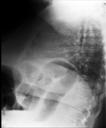
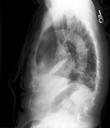
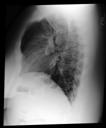
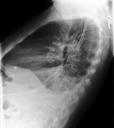
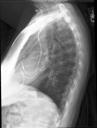
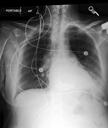
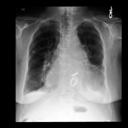
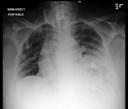
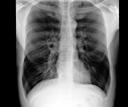
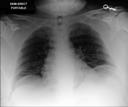

In [96]:
mk.config.DisplayOptions.max_rows = 10
error_dp = score_dp.lz[(score_dp["prob"] > 0.5).numpy() != (score_dp[target] == 1)]
error_dp = error_dp.lz[(error_dp[target] == 1)]
error_dp[["cxr_jpg_1024", "prob", target, correlate]]

In [155]:
mk.config.DisplayOptions.max_rows = 40

dp = score_dp
prob_indices = (dp["prob"] > 0.5).data.numpy().astype(bool)
attr_emb = dp.lz[prob_indices]["emb"].data.mean(axis=0) #average embedding of predicted lung images
ref_emb = dp.lz[dp[target] == 1]["emb"].data.mean(axis=0) #average embedding of true lung images

#error_1_indices = ((dp["prob"] > 0.5).data.numpy().astype(bool)) & ((dp[target] == 0).data.astype(bool))
#error_1_emb =  dp.lz[error_1_indices]["emb"].data.mean(axis=0)

#error_2_indices = ((dp["prob"] < 0.5).data.numpy().astype(bool)) & ((dp[target] == 1).data.astype(bool))
#error_2_emb =  dp.lz[error_2_indices]["emb"].data.mean(axis=0)

scores = np.dot(words_dp["emb"].data, attr_emb - ref_emb)
words_dp["score"] = scores
words_dp.lz[(-scores).argsort()[:20]]

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (NumpyArrayColumn),score (NumpyArrayColumn)
0,prepositions,1488,42886,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.220337
1,fotball,590,77066,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.210571
2,carburetors,1199,48866,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.209961
3,intelligences,656,72036,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.189575
4,mobiles,935,57441,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.188843
5,homepage,1957,36054,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.184082
6,patents,20319,7790,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.180054
7,instrumentation,14720,9795,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.177979
8,spreads,6583,16630,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.177979
9,microcontrollers,866,60272,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.177124


### Analyze with Multimodal Embeddings